# Parcialito II -  Segmentación - Brisa Rojas (60535)


Primero se hace el import de librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from typing import Tuple

También vamos a cargar la imagen que vamos a trabajar desde su `path`.

In [2]:
path = './img12.jpg'
img12 = cv2.imread(path,0)

Vamos a ver con que imagen vamos a trabajar.

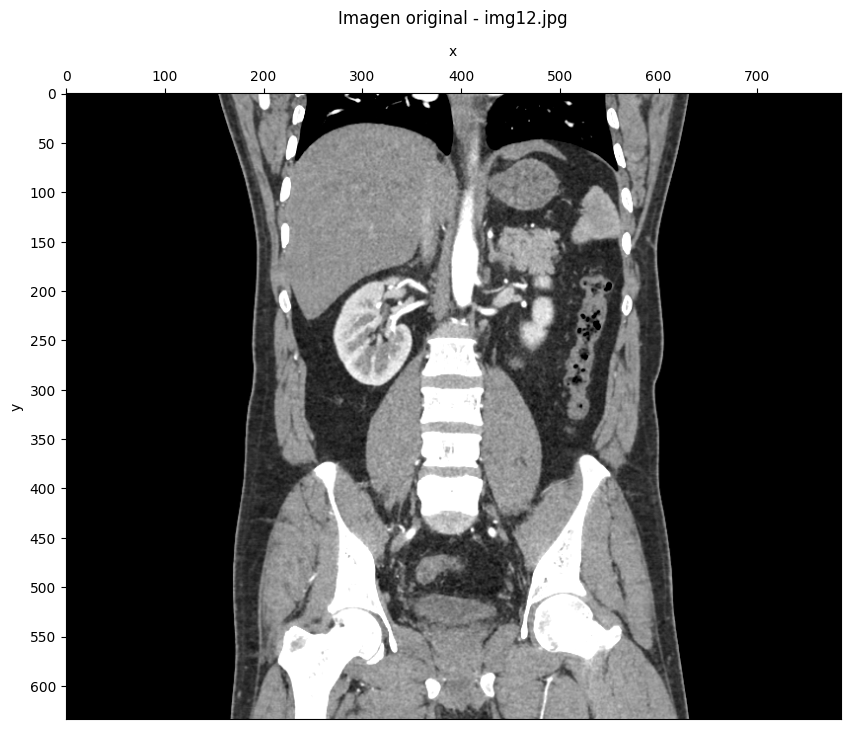

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img12, cmap='gray')

# Acomodamos el título y los ejes
ax.set_title('Imagen original - img12.jpg', pad = 50)
ax.set_xlabel('x')
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = img12.shape[0]
ax.set_yticks(np.arange(0, y, 50))


# Mostramos la imagen
plt.show()

Se ve que la anatomía de la imagen es normal: a simple vista no se ven anomalías como heridas o masas extrañas.
Hay organos del abdomen como el hígado, el bazo, los riñones (del derecho un corte completo y del izquierdo apenas un pequeño area), el páncreas, el intestino (mejor dicho un pequeño tramo), etc. Del esqueleto se ve la columna vertebral lumbar, un corte de las costillas y los huesos pertenecientes a la cadera.

## Objetivo

Com o a simple vista no veo anomalías, planteo como objetivo de este trabajo recortar el riñon e intentar segmentar las diferentes partes que lo componen: medula y corteza.
También otro objetivo simple puede ser contar la cantidad de organos y huesos que se ven en la imagen e ir probando diferentes técnicas de segmentación en general.

# Objetivo I: riñón 
De la imagen original, se ve que el riñon derecho está completo y el izquierdo está cortado. Por lo tanto, voy a trabajar con el riñon derecho.

Además, se pueden definir las coordenadas (a ojo, y por lo tanto aproximadas) para recortar el riñon derecho de la imagen original.

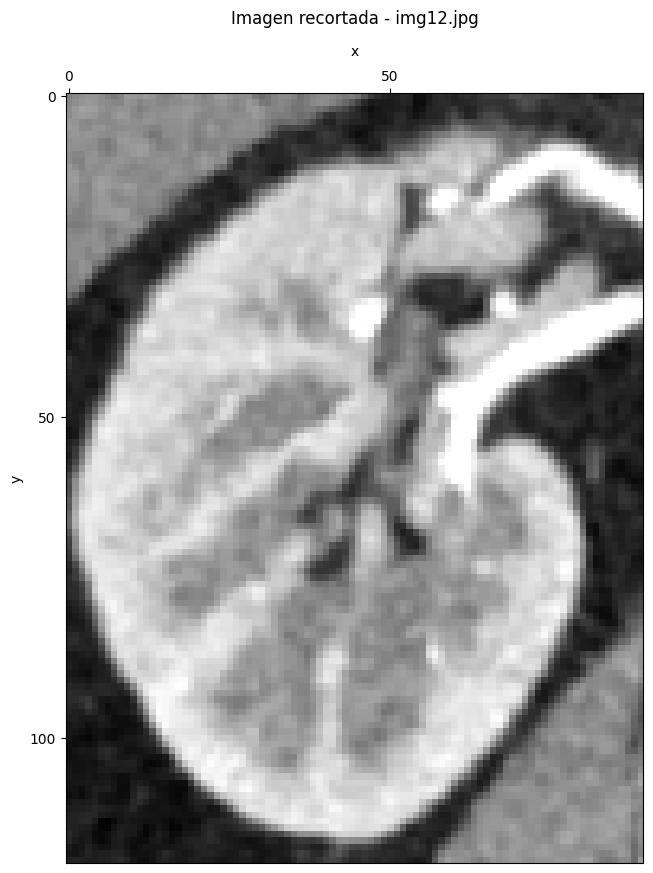

In [4]:
# Recortar imagen entre limites en x e y
yMin = 180
yMax = 300

xMin = 270
xMax = 360

img12_rec = img12[yMin:yMax, xMin:xMax]

#Volvemos a ver la imagen

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img12_rec, cmap='gray')

# Acomodamos el título y los ejes
ax.set_title('Imagen recortada - img12.jpg', pad = 50)
ax.set_xlabel('x')
x = img12_rec.shape[1]
ax.set_xticks(np.arange(0, x, 50))
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = img12_rec.shape[0]
ax.set_yticks(np.arange(0, y, 50))


# Mostramos la imagen
plt.show()

## Preprocesamiento

Vamos a ver si es necesario mejorar la imagen antes de segmentarla.
Primero defino una función que realiza el histograma.

In [5]:
def histograma(img :np.ndarray, verbose=False, normalized=False, plot=True, grid=False, accumulated=False) -> np.ndarray or None :
    '''
    Función que calcula el histograma de una imagen
    Parámetros: 
        img: imagen de entrada
        verbose: si es True devuelve el arreglo de valores de frecuencia
        normalized: si es True devuelve el histograma normalizado respecto al número de píxeles totales
        plot: si es True muestra el histograma
        grid: si es True muestra las líneas de la grilla
        accumulated: si es True muestra el histograma acumulado y normalizado sobre el histograma
    ''' 

    histX = np.arange(0, 256, 1)
    #crear array de numpy de 256 posiciones [0,255]
    histY = np.zeros(256)
    #recorrer la imagen
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            #sumar 1 al valor del histograma correspondiente al valor de la imagen
            index = int(img[i,j]) #  por cualquier cosa que no sea un entero (ej: 1.0, 0.0, 255.0)
            histY[index] += 1

    if normalized:
        histY = histY / (img.shape[0] * img.shape[1]) #normalizar respecto al número de píxeles totales

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))

        if grid:
            ax.grid(True)

        # Mostramos el histograma
        ax.bar(histX,histY, width=1.4, color='xkcd:sky blue', capstyle='butt', edgecolor='black', linewidth=0.2)
        ax.set_title('Histograma de intensidades de gris', pad = 10)
        ax.set_xlabel('Intensidad de gris')
        ax.set_xlim(0, 255)
        if normalized:
            ax.set_ylabel('Frecuencia relativa de aparición del tono de gris')
            # agregar un pad a la etiqueta del eje y para que no se solape con el valor de la barra
        else:
            ax.set_ylabel('Frecuencia de aparición del tono de gris')
        ax.yaxis.set_label_position("left")
        


        if accumulated:
            accHistY = np.zeros(256) #array de numpy de 256 posiciones [0,255] para los valores posibles de intensidad de gris
            accHistY[0] = histY[0] #el primer valor del histograma acumulado es el primer valor del histograma
            for i in range(1, 256): 
                accHistY[i] = accHistY[i-1] + histY[i] # valores acumulados = valores anteriores + valor actual
            
            accHistY = accHistY / (img.shape[0] * img.shape[1])  #normalizamos el histograma acumulado

            # create a second y-axis on the right side of the plot and plot the accumulated histogram 
            ax2 = ax.twinx()
            ax2.plot(histX, accHistY, color='xkcd:greyish purple', linewidth=2)
            ax2.set_ylim(0, 1) #seteamos el rango de valores del eje y del histograma acumulado
            ax2.set_ylabel("Frecuencia normalizada de aparición acumulada")
            ax2.yaxis.set_label_position("right")
            ax2.yaxis.tick_right()
            ax2.legend(['Histograma acumulado'], loc='upper left')

        plt.show()
    
    if verbose:
        return histY
    '''
        Se devuelve histY por si se quiere luego analizar con otra función
    '''


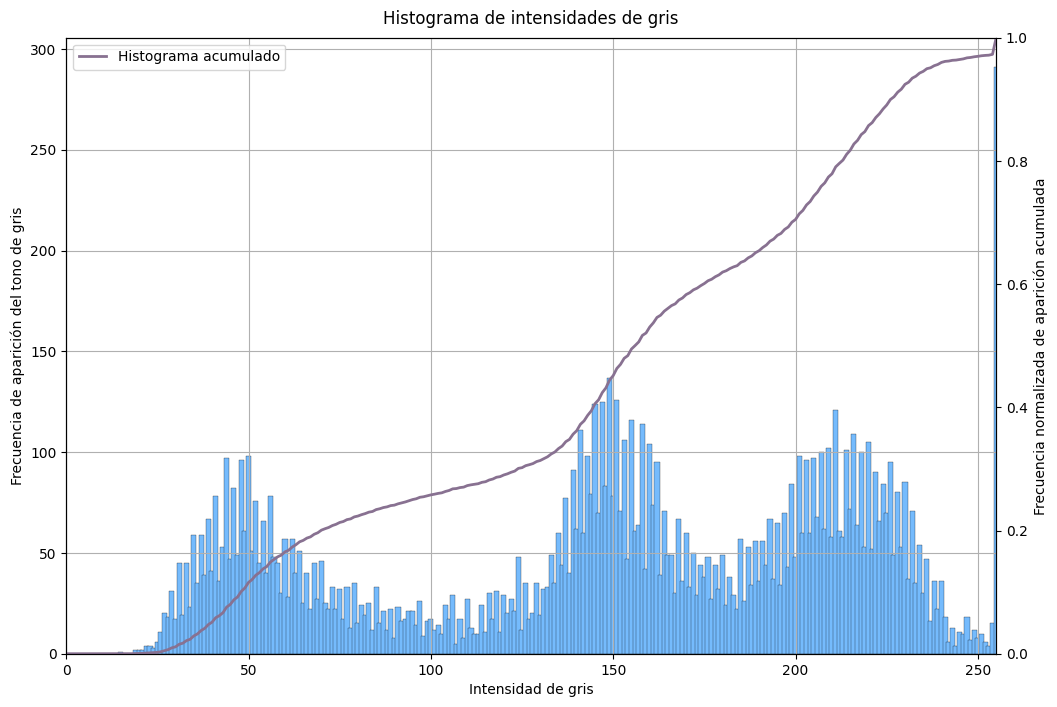

In [6]:
histograma(img12_rec, plot=True, grid=True, accumulated=True)

El histograma de la imagen original tiene 3 'objetos' bien separados, con picos en 40, 150 y 220 aproximadamente, y un pico en 255. 

Respecto a los objetos:: a ojo podemos sospechar que el primero es el fondo y el segundo está conformado por el riñon (las cálices) los tejidos aledaños como el hígado y por último, el tercero la corteza del riñon. 

Si bien las vértebras no son un objeto de interés, no las recorté anteriormente porque así puedo intentar eliminarlas usando segmentación y no recorte de imagen.

El contraste en general es bueno, hay una buena distribución de los valores de intensidad de la imagen, pero se puede mejorar, por eso voy a realizar un ecualizado de histograma. Para eso defino una función que lo realiza.

In [7]:
def ecualizar(img:np.ndarray) -> np.ndarray:
    '''
    Función que ecualiza una imagen de entrada
    Parámetros:
        img: imagen de entrada numpy.ndarray
    '''
    hist = histograma(img, normalized=True, plot=False, verbose=True) #histograma normalizado

    CDF = np.zeros(256) # CDF : cumulative distribution function // histograma acumulado
    CDF[0] = hist[0]
    for i in range(1, 256):
        CDF[i] = CDF[i-1] + hist[i] # valores acumulados = valores anteriores + valor actual
    CDF *=  255 # llevamos los valores al rango [0,255]
    
    imgEcualizada = np.zeros(img.shape) 
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            imgEcualizada[i,j] = CDF[int(img[i,j])]
            
    return imgEcualizada

In [8]:
imgEc = img12_rec
imgEc = ecualizar(imgEc)

Primero veo como cambio el histograma luego de ecualizar

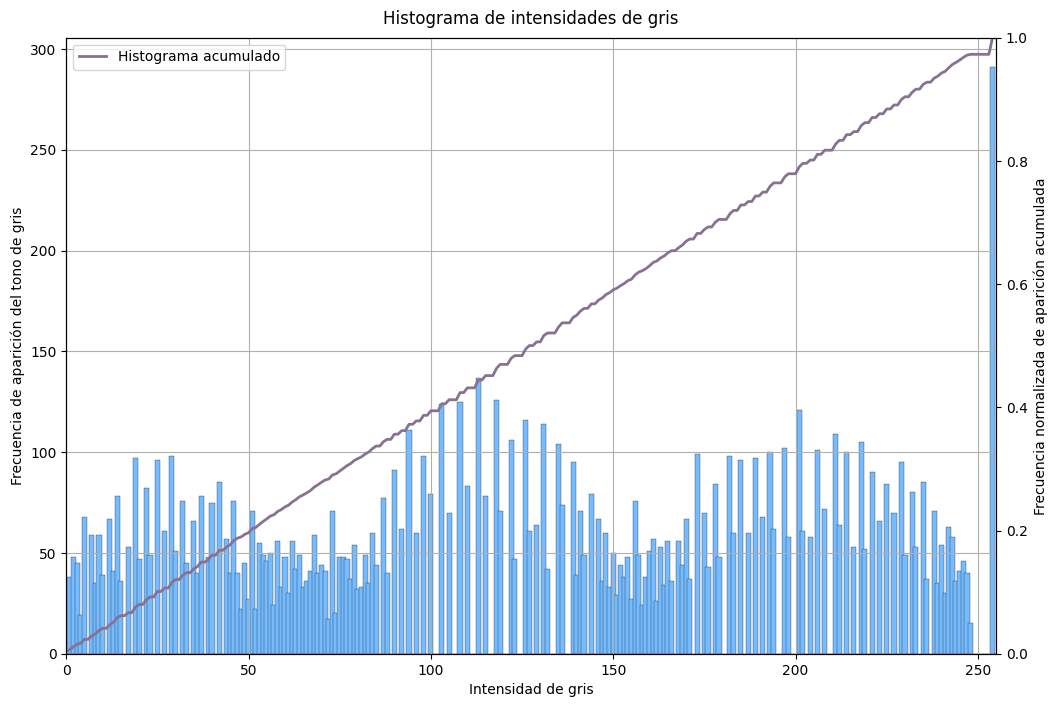

In [9]:
histograma(imgEc, plot=True, grid=True, accumulated=True)

Luego de ecualizar, observando solo el histograma vemos que se utiliza más el rango de gris (con un histograma acumulado casi lineal) y que el pico se mantiene.

Ahora veamos como se ve la imagen luego de ecualizar el histograma.

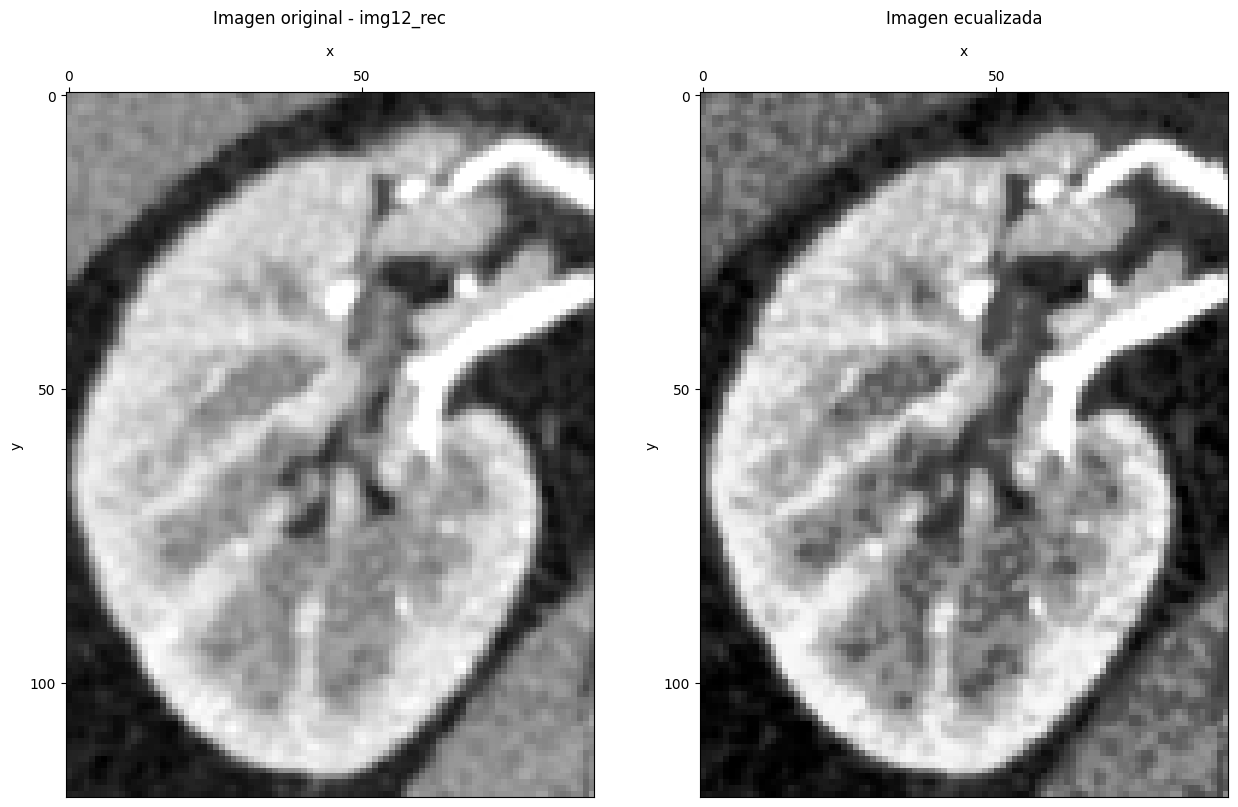

In [10]:
# Mostramos la imagen comparada con la original una al lado de la otra
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# imagen original
ax[0].imshow(img12_rec, cmap='gray')
ax[0].set_title('Imagen original - img12_rec', pad = 50)
ax[0].set_xlabel('x')
x = img12_rec.shape[1]
ax[0].set_xticks(np.arange(0, x, 50))
ax[0].xaxis.set_label_position('top')
ax[0].xaxis.labelpad = 10
ax[0].xaxis.set_ticks_position('top')
ax[0].set_ylabel('y')
y = img12_rec.shape[0]
ax[0].set_yticks(np.arange(0, y, 50))

#imagen filtrada
# imagen original
ax[1].imshow(imgEc, cmap='gray')
ax[1].set_title('Imagen ecualizada', pad = 50)
ax[1].set_xlabel('x')
ax[1].set_xticks(np.arange(0, x, 50))
ax[1].xaxis.set_label_position('top')
ax[1].xaxis.labelpad = 10
ax[1].xaxis.set_ticks_position('top')
ax[1].set_ylabel('y')
ax[1].set_yticks(np.arange(0, y, 50))

plt.show()


In [11]:
img12_rec = imgEc

## Segmentación por Otsu
Defino una función que realiza la segmentación por Otsu.

In [12]:
NUM_BINS = 256 # número de bins del histograma
def otsu(image: np.ndarray) -> tuple[np.ndarray, np.uint8]: 
    '''
    Función que calcula el umbral óptimo de una imagen de entrada con el método de Otsu
    
    Parametros:
        image: imagen de entrada numpy.ndarray
        
    Return:
        segmented: imagen segmentada binaria, numpy.ndarray
        optimalThreshold: umbral óptimo, np.uint8
    '''
    
    size = image.shape
    if len(size) > 2:
        image = image[:, :, 0]

    probability = histograma(image, plot=False, verbose=True)
    probability = probability / (size[0] * size[1])
    
    variance = []
    weight0, weight1, mean0, mean1 = 0, 1, 0, 0

    for threshold in range(NUM_BINS):
        weight0 = np.sum(image <= threshold)
        weight1 = np.sum(image > threshold)

        if weight0 != 0 and weight1 != 0:
            vector1 = np.linspace(0, threshold, num=threshold+1, dtype=int)
            mean0 = np.inner(vector1, probability[0:threshold+1]) / weight0
            vector2 = np.linspace(threshold+1, NUM_BINS-1, num=NUM_BINS-threshold-1, dtype=int)
            mean1 = np.inner(vector2, probability[threshold+1:NUM_BINS]) / weight1

        v = weight0 * weight1 * (mean0 - mean1) ** 2
        variance.append(v)

    optimalThreshold = variance.index(max(variance))
    segmented = (image >= optimalThreshold) * 1

    return segmented, optimalThreshold


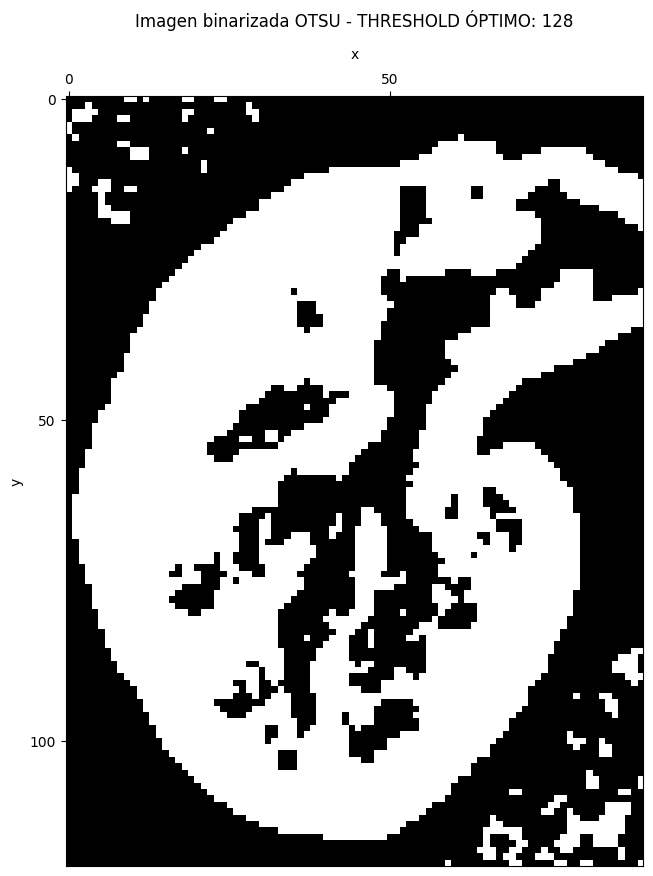

In [13]:
# Aplicamos el algoritmo de Otsu a la imagen
imgOtsuBin, umbralOtsu = otsu(img12_rec)

# Mostramos la imagen binaria resultante
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(imgOtsuBin, cmap='gray')

# Acomodamos el título y los ejes
ax.set_title(f'Imagen binarizada OTSU - THRESHOLD ÓPTIMO: {umbralOtsu}', pad = 50)
ax.set_xlabel('x')
x = imgOtsuBin.shape[1]
ax.set_xticks(np.arange(0, x, 50))
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = imgOtsuBin.shape[0]
ax.set_yticks(np.arange(0, y, 50))

# Mostramos la imagen
plt.show()

En principio vemos que encontró un umbral de 128, que de la imagen original se ve que es un valor que separa bien el fondo del resto de la imagen. Vamos a ver que se obtiene cuando multiplico la imagen original por la imagen binaria obtenida con el método de Otsu.

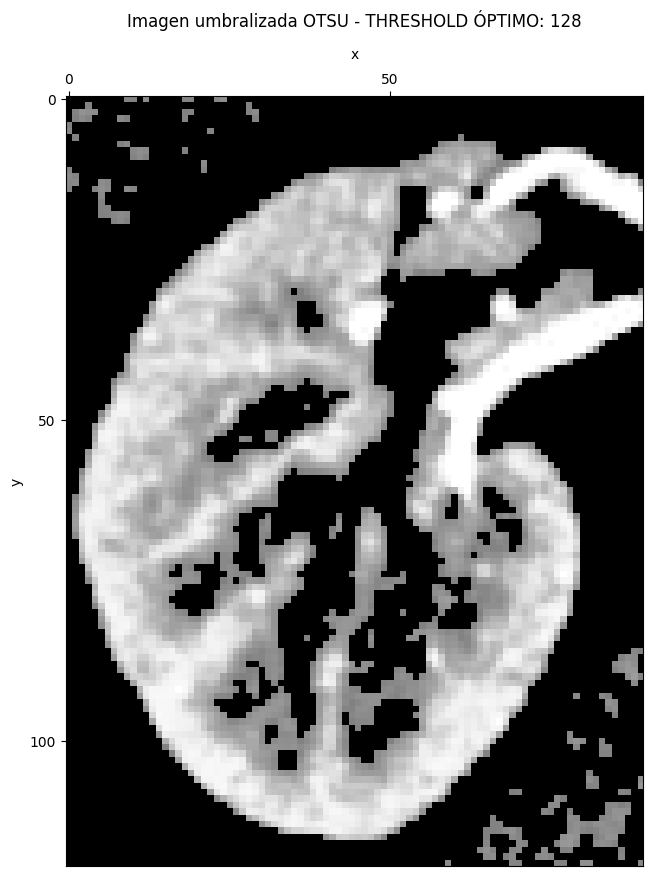

In [14]:
imgOtsu =  (imgOtsuBin / 255) *  img12_rec # Multiplicamos la imagen binaria por la original para obtener la imagen segmentada dividiendo por 255 ya que la imagen "binaria" tiene valores 0 y 255

# Mostramos la imagen binaria resultante
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(imgOtsu, cmap='gray')

# Acomodamos el título y los ejes
ax.set_title(f'Imagen umbralizada OTSU - THRESHOLD ÓPTIMO: {umbralOtsu}', pad = 50)
ax.set_xlabel('x')
x = imgOtsu.shape[1]
ax.set_xticks(np.arange(0, x, 50))
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = imgOtsu.shape[0]
ax.set_yticks(np.arange(0, y, 50))

# Mostramos la imagen
plt.show()



Se observa que el umbral hallado es bueno para separar el fondo del resto de la imagen, pero no es bueno para separar el riñon del resto de la imagen. Esto se debe a que el riñon tiene una intensidad similar a los otros tejidos que se ven, y por lo tanto no se puede separar bien con un umbral global.


## Segmentación por Region Growing
Defino una función que realiza la segmentación por Region Growing. La idea es segmentar en primer lugar el riñon por completo del fondo, y luego segmentar por partes: la corteza del riñon por un lado y por otro lado la médula del riñon.

Para esto defino la función `regionGrowing`

In [15]:
def regionGrowing(img, seed, threshold):
    """
    Implementación del algoritmo de Region Growing para segmentar una imagen en regiones homogéneas.

    Parámetros:
        - img: matriz NumPy que representa la imagen a segmentar.
        - seed: tupla que indica las coordenadas (fila, columna) de la semilla inicial.
        - threshold: valor umbral para determinar la homogeneidad de la región.

    Retorna:
        - reg: matriz NumPy que representa la región segmentada.
    """
    # Creamos una matriz de etiquetas con el mismo tamaño que la imagen
    labels = np.zeros_like(img, dtype=np.uint8)
    # Marcamos la semilla inicial como región activa
    labels[seed] = 1
    # Creamos una lista para almacenar los píxeles que pertenecen a la región activa
    active_pixels = [seed]

    # Iteramos mientras haya píxeles activos en la lista
    while active_pixels:
        # Tomamos el primer pixel activo y lo eliminamos de la lista
        pixel = active_pixels.pop(0)
        # Obtenemos los vecinos del pixel
        neighborhood = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
        # Calculamos las coordenadas de los vecinos del pixel en base a pixel y neighborhood
        neighbors = neighborhood + [pixel, pixel, pixel, pixel]
        # Eliminamos los vecinos que están fuera de la imagen
        valid_neighbors = neighbors[(neighbors[:, 0] >= 0) & (neighbors[:, 0] < img.shape[0]) & 
                                    (neighbors[:, 1] >= 0) & (neighbors[:, 1] < img.shape[1])]
        # Iteramos sobre los vecinos para agregarlos a la región activa
        for neighbor in valid_neighbors:
            # Si el vecino no ha sido etiquetado y cumple el criterio de homogeneidad, lo agregamos a la región activa            
            if labels[neighbor[0], neighbor[1]] == 0 and np.allclose(img[neighbor[0], neighbor[1]], img[pixel[0], pixel[1]], atol=threshold):
                labels[neighbor[0], neighbor[1]] = 1
                active_pixels.append(neighbor)

    return labels


Primero veo si se puede segmentar el riñon completo de su fondo, para eso defino 1 semilla a mano. Esto lo voy a hacer sobre la imagen entera ecualizada.

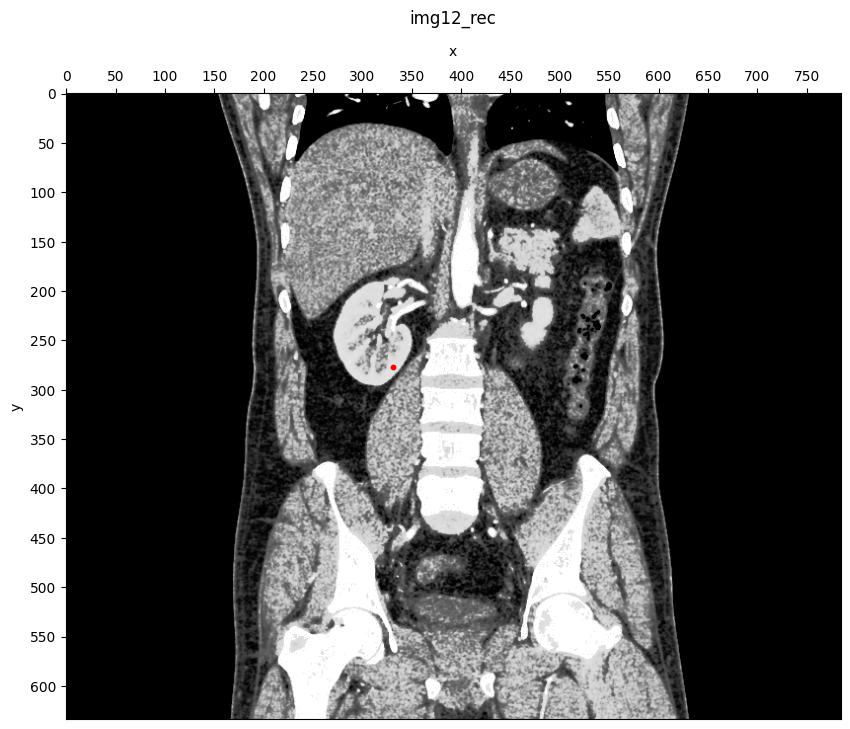

In [16]:
img12Ec = ecualizar(img12)
# Mostramos la imagen 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img12Ec, cmap='gray')

# Acomodamos el título y los ejes
ax.set_title(f'img12_rec', pad = 50)
ax.set_xlabel('x')
x = img12Ec.shape[1]
ax.set_xticks(np.arange(0, x, 50))
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = img12Ec.shape[0]
ax.set_yticks(np.arange(0, y, 50))

# Agrego las semillas como un punto
ax.scatter(xMin + 61, yMin + 97, s=10, c='red') # Semilla 1

# Mostramos la imagen
plt.show()


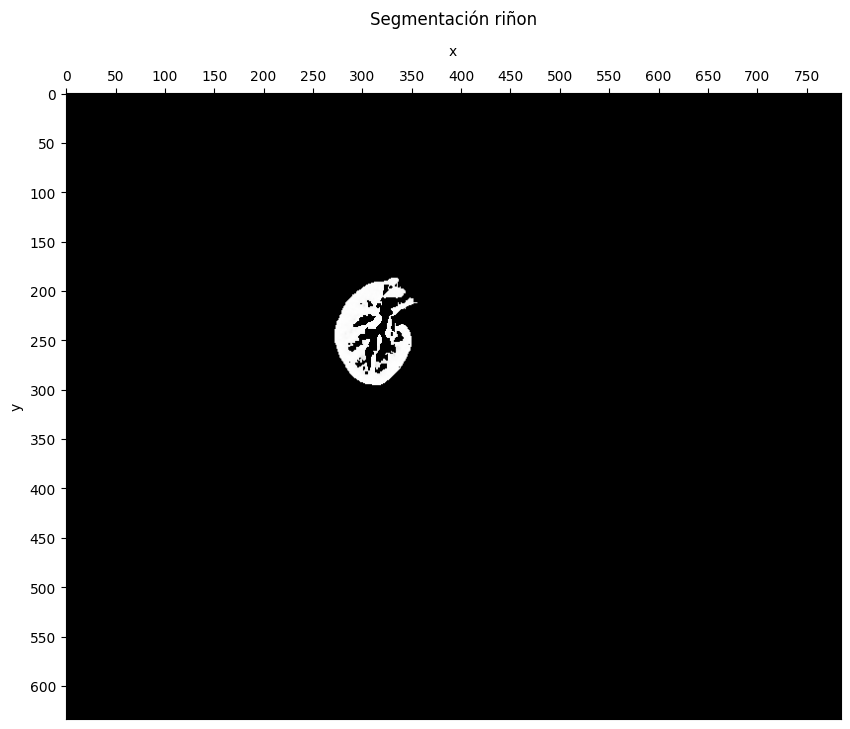

In [17]:
umbral = 5 # Umbral de homogeneidad
rinonBin = regionGrowing(img12Ec, (yMin + 97, xMin + 61), umbral)

# Mostramos la imagen 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow((rinonBin * img12Ec), cmap='gray')

# Acomodamos el título y los ejes
ax.set_title(f'Segmentación riñon', pad = 50)
ax.set_xlabel('x')
x = (rinonBin * img12Ec).shape[1]
ax.set_xticks(np.arange(0, x, 50))
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = (rinonBin * img12Ec ).shape[0]
ax.set_yticks(np.arange(0, y, 50))
# Mostramos la imagen
plt.show()

Ahora voy a segmentar en la imagen recortada, cada zona del riñon por separado. Primero hay que ver cual es una buena coordenada para la semilla inicial graficandola con un punto sobre la imagen que ya tengo.

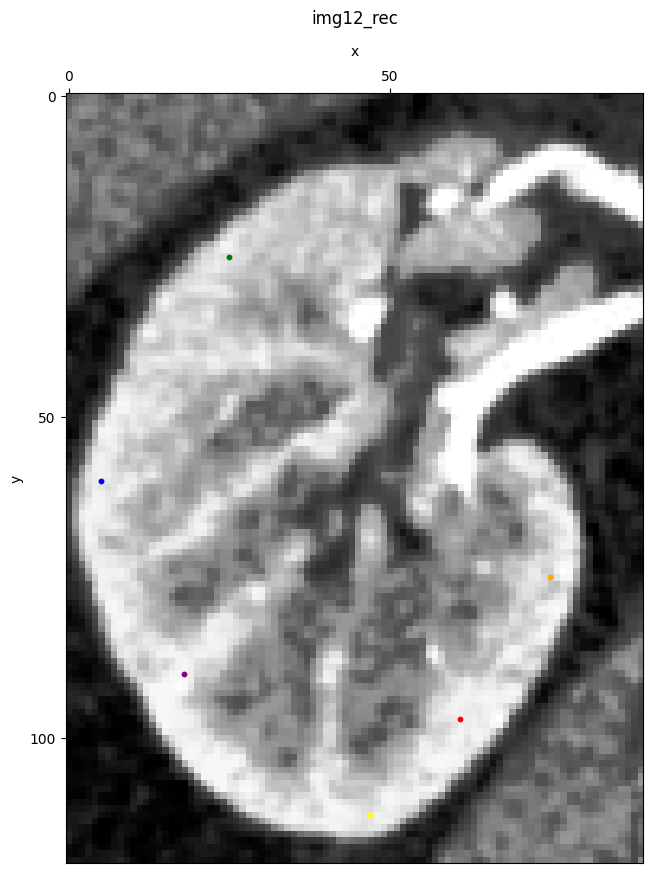

In [18]:
# Mostramos la imagen 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img12_rec, cmap='gray')

# Acomodamos el título y los ejes
ax.set_title(f'img12_rec', pad = 50)
ax.set_xlabel('x')
x = img12_rec.shape[1]
ax.set_xticks(np.arange(0, x, 50))
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = img12_rec.shape[0]
ax.set_yticks(np.arange(0, y, 50))

# Agrego las semillas como un punto
ax.scatter(61,97, s=10, c='red') # Semilla 1
ax.scatter(5,60, s=10, c='blue') # Semilla 2
ax.scatter(25,25, s=10, c='green') # Semilla 3
ax.scatter(47,112, s=10, c='yellow') # Semilla 4
ax.scatter(18,90, s=10, c='purple') # Semilla 5
ax.scatter(75,75, s=10, c='orange') # Semilla 6



# Mostramos la imagen
plt.show()

Tras probar con varias semillas distintas y varias tolerancias distintas puedo concluir lo siguiente: 
- El umbral de tolerancia no puede ser muy grande porque se segmenta más que solo la corteza. Pero si lo bajo demasiado segmenta 3 o 4 pixeles vecinos unicamente.
-  No importa que semilla tome (dentro de la corteza) no hay ninguna que segmente la corteza completa.

Decido entonces hacer un regionGrowing con varias semillas y un umbral bajo (segmento poco area pero me aseguro de no segmentar médula), y luego sumar todas las segmentaciones para obtener la corteza completa (dentro de lo posible).

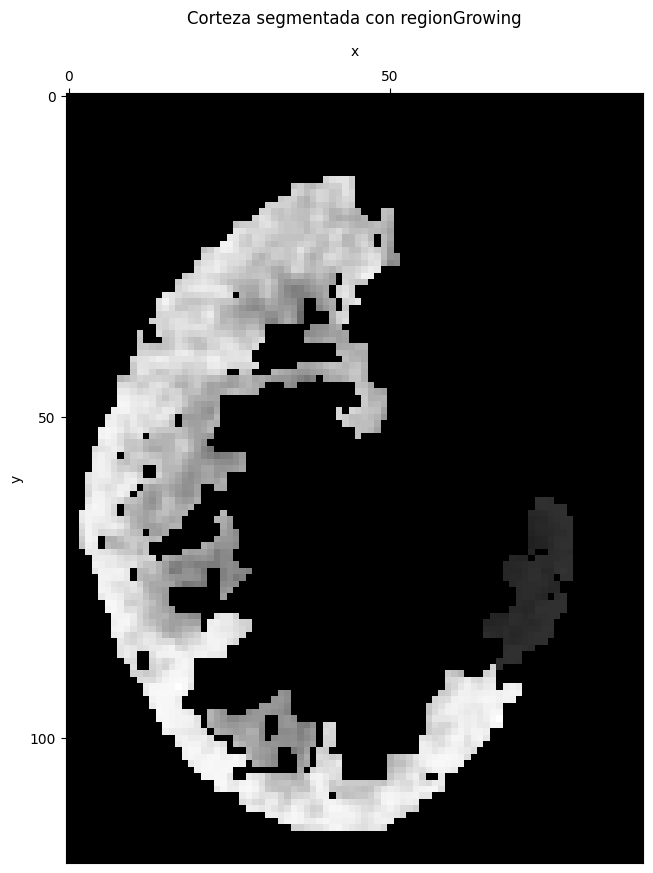

In [19]:
umbral = 12 # Umbral de homogeneidad
cortezaBin = regionGrowing(img12_rec, (97, 61), umbral) + regionGrowing(img12_rec, (60,5), umbral) + regionGrowing(img12_rec, (25,25), umbral) + regionGrowing(img12_rec, (110,40), umbral) + regionGrowing(img12_rec, (90,18), umbral) + regionGrowing(img12_rec, (75,75), umbral)
# Mostramos la imagen segmentada resultante
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cortezaBin * img12_rec, cmap='gray')

# Acomodamos el título y los ejes
ax.set_title(f'Corteza segmentada con regionGrowing', pad = 50)
ax.set_xlabel('x')
x = (cortezaBin * img12_rec).shape[1]
ax.set_xticks(np.arange(0, x, 50))
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = (cortezaBin * img12_rec).shape[0]
ax.set_yticks(np.arange(0, y, 50))

# Mostramos la imagen
plt.show()


Lo que se obtuvo en la segmentación observada arriba es gran parte de la corteza aunque no el 100%, pero no hay médula incluida. 
Ahora voy a segmentar por otra parte la medula. Para eso, voy a buscar que semillas debería usar y que umbral, de la misma forma que lo hice con la corteza: la ubicación de la semilla a ojo y el umbral, probando el algoritmo y observando los resultados.


Busco las posiciones de las semillas:

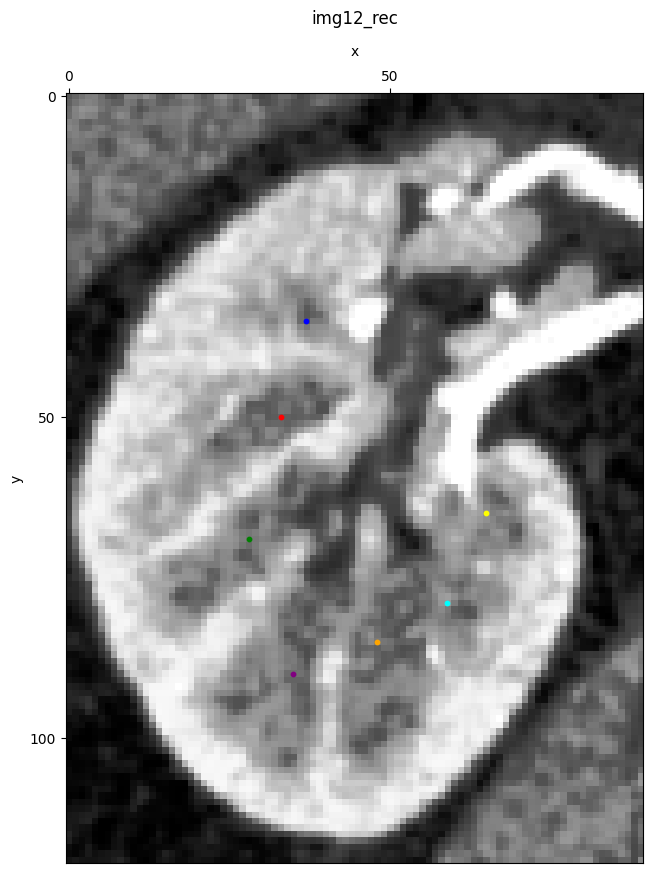

In [20]:
# Mostramos la imagen 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img12_rec, cmap='gray')

# Acomodamos el título y los ejes
ax.set_title(f'img12_rec', pad = 50)
ax.set_xlabel('x')
x = img12_rec.shape[1]
ax.set_xticks(np.arange(0, x, 50))
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = img12_rec.shape[0]
ax.set_yticks(np.arange(0, y, 50))

# Agrego las semillas como un punto
ax.scatter(33,50, s=10, c='red') # Semilla 1
ax.scatter(37,35, s=10, c='blue') # Semilla 2
ax.scatter(28,69, s=10, c='green') # Semilla 3
ax.scatter(35,90, s=10, c='purple') # Semilla 4
ax.scatter(48,85, s=10, c='orange') # Semilla 5
ax.scatter(65,65, s=10, c='yellow') # Semilla 6
ax.scatter(59,79, s=10, c='#00FFFF') # Semilla 7


# Mostramos la imagen
plt.show()

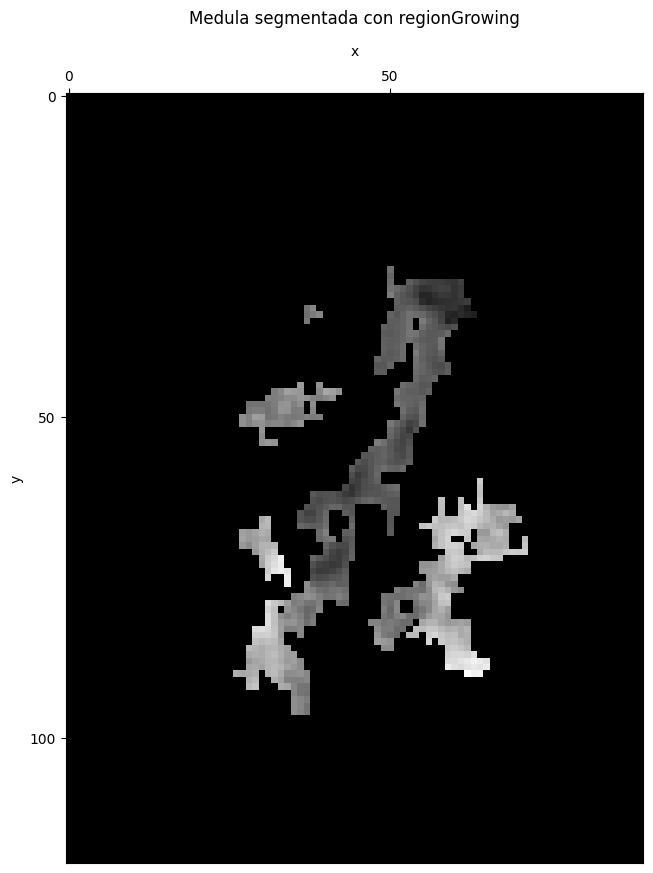

In [21]:
umbral = 11 # Umbral de homogeneidad
medulaBin = regionGrowing(img12_rec, (50, 33), umbral) + regionGrowing(img12_rec, (35,37), umbral) + regionGrowing(img12_rec, (69,28), umbral) + regionGrowing(img12_rec, (90,35), umbral) + regionGrowing(img12_rec, (85,48), umbral) + regionGrowing(img12_rec, (65,65), umbral) + regionGrowing(img12_rec, (79,59), umbral)

# Mostramos la imagen segmentada resultante
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(medulaBin * img12_rec, cmap='gray')

# Acomodamos el título y los ejes
ax.set_title(f'Medula segmentada con regionGrowing', pad = 50)
ax.set_xlabel('x')
x = (medulaBin * img12_rec).shape[1]
ax.set_xticks(np.arange(0, x, 50))
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = (medulaBin * img12_rec).shape[0]
ax.set_yticks(np.arange(0, y, 50))

# Mostramos la imagen
plt.show()

No pude encontrar un umbral que segmente correctamente la medula, ya que o no segmento nada o segmento el riñon entero con una diferencia de aumentar el umbral en +1.

## Segmentación con K means
Defino una función que realiza la segmentación por K means.

In [22]:
def k_means(image, k, max_iterations=10):
    # Convertir la imagen en un arreglo NumPy
    img_arr = np.array(image)
    
    # Obtener la forma de la imagen
    rows, cols = img_arr.shape
    
    # Aplanar la matriz de píxeles
    pixels = img_arr.reshape(rows*cols, 1)
    
    # Inicializar los centroides aleatoriamente
    centroids = np.random.rand(k, 1) * 255
    
    # Iterar hasta que los centroides se estabilicen o se alcance el número máximo de iteraciones
    for i in range(max_iterations):
        # Calcular las distancias entre los píxeles y los centroides
        distances = np.linalg.norm(pixels[:, np.newaxis] - centroids, axis=2)
        
        # Asignar cada pixel al centroide más cercano
        labels = np.argmin(distances, axis=1)
        
        # Actualizar los centroides como la media de los píxeles asignados a cada centroide
        for j in range(k):
            mask = labels == j
            if np.any(mask):
                centroids[j] = np.mean(pixels[mask], axis=0)
        
    # Asignar cada pixel al centroide final más cercano
    distances = np.linalg.norm(pixels[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)
    
    # Crear una matriz de la misma forma que la imagen original con los valores del centroide asignados a cada píxel
    segmented = centroids[labels].reshape(rows, cols)
    return np.uint8(segmented)


La idea es ir probando que tan útil es este tipo de segmentación para segmentar organos, huesos y fondo por separado. E incluso, dentro de lo que sería tejidos blandos, ver si se pueden segmentar por separado con este método. Para esto voy a probar con distintos valores de clusters K, de 2 en adelante.

El primer intento es con `k=2`, la idea es separar fondo de objeto en este caso, y se obtiene lo siguiente:

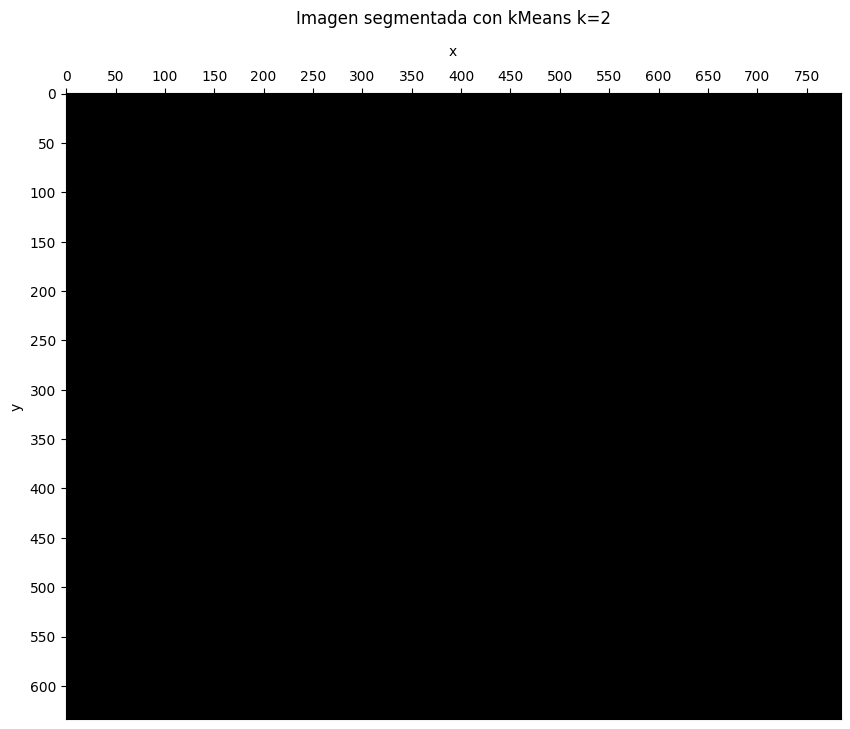

In [23]:
imgKMeans = k_means(img12Ec, 2)
# Mostramos la imagen segmentada resultante
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(imgKMeans, cmap='gray')
# Acomodamos el título y los ejes
ax.set_title(f'Imagen segmentada con kMeans k=2', pad = 50)
ax.set_xlabel('x')
x = imgKMeans.shape[1]
ax.set_xticks(np.arange(0, x, 50))
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = imgKMeans.shape[0]
ax.set_yticks(np.arange(0, y, 50))

# Mostramos la imagen
plt.show()


Podemos ver que segmenta bien. En líneas generales, todas las zonas están bien definidas y no presentan gaps.

Voy a probar ahora con `k=3`, la idea es separar fondo, huesos y organos blandos. Se obtiene lo siguiente:

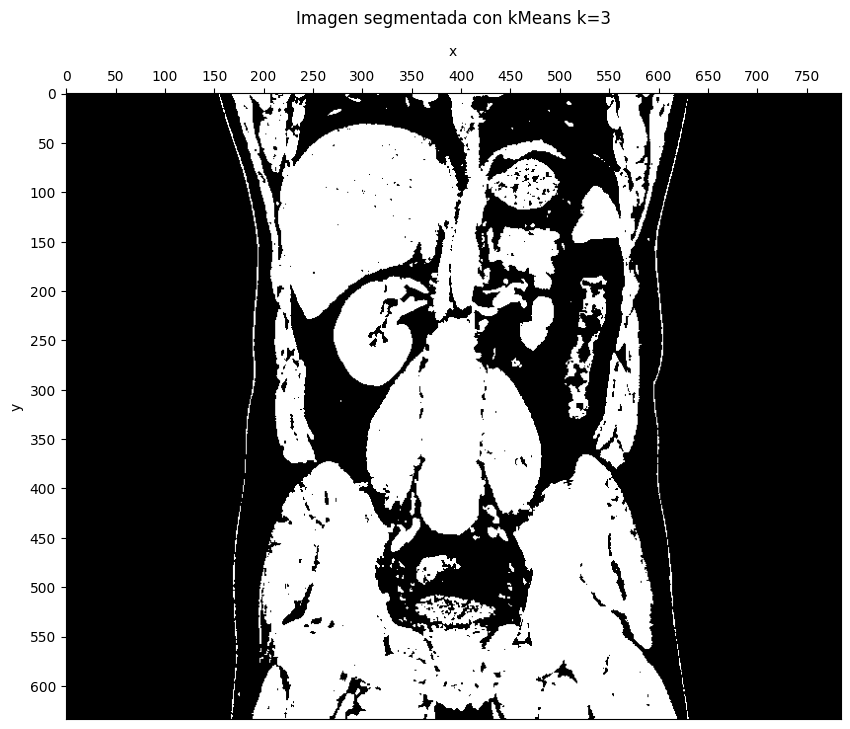

In [24]:
imgKMeans = k_means(img12Ec, 3)
# Mostramos la imagen segmentada resultante
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(imgKMeans, cmap='gray')

# Acomodamos el título y los ejes
ax.set_title(f'Imagen segmentada con kMeans k=3', pad = 50)
ax.set_xlabel('x')
x = (imgKMeans).shape[1]
ax.set_xticks(np.arange(0, x, 50))
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = (imgKMeans).shape[0]
ax.set_yticks(np.arange(0, y, 50))

# Mostramos la imagen
plt.show()


Como vemos, no se segmento bien. Esto se debe a que como mencioné anteriormente, la imagen presenta texturas no uniformes (una especie de ruido) que además se amplificaba al ecualizar. Es interesante ver si con la imagen original ocurre lo mismo, voy a probar con esa

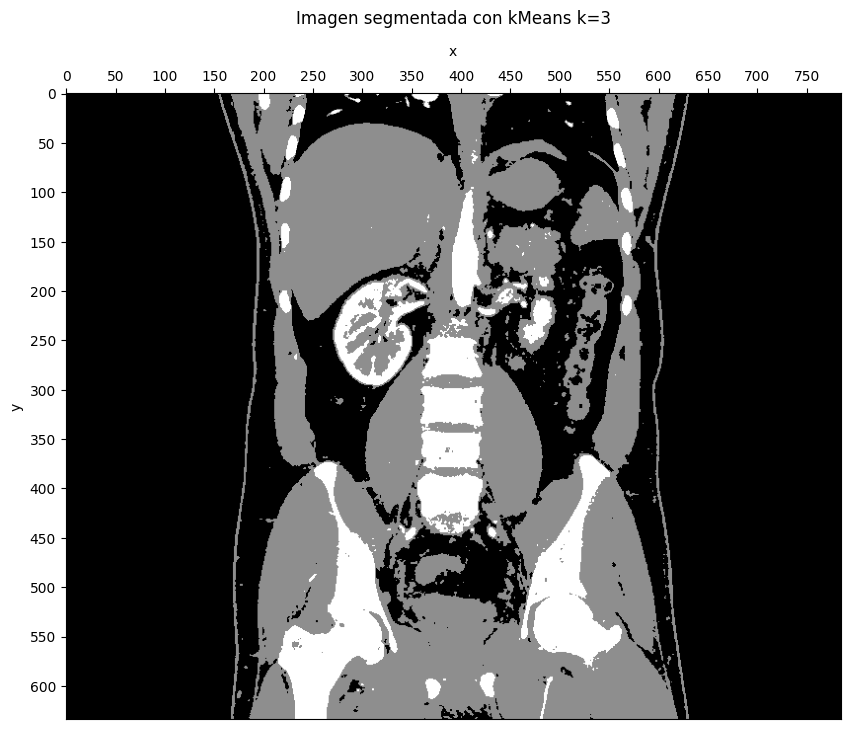

In [25]:
imgKMeans = k_means(img12, 3)
# Mostramos la imagen segmentada resultante
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(imgKMeans, cmap='gray')

# Acomodamos el título y los ejes
ax.set_title(f'Imagen segmentada con kMeans k=3', pad = 50)
ax.set_xlabel('x')
x = (imgKMeans).shape[1]
ax.set_xticks(np.arange(0, x, 50))
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = (imgKMeans).shape[0]
ax.set_yticks(np.arange(0, y, 50))

# Mostramos la imagen
plt.show()


Con la imagen original se obtiene una mejor segmentación (en el sentido de que no se amplifica el ruido), pero no se segmenta bien en distintas categorías.
Esto se debe a que los huesos y cierta parte de los organos blandos (ej corteza del riñon) tienen una intensidad similar, y por lo tanto no se pueden separar con este método. Si se segmentaran las partes que en esta técnica se ven en un cluster no correspondiente por otro método, se podrían usar para generar una imagen híbrida (por haberse hecho con 2 técnicas) que muestre fondo, organos blandos y  huesos por separado.

Ahora veo como me quedaría con un cluster de los 3 que segmenté (cualquiera de los 3 me sirve) para probar usar bounding box y detectar distintos objetos y contarlos.

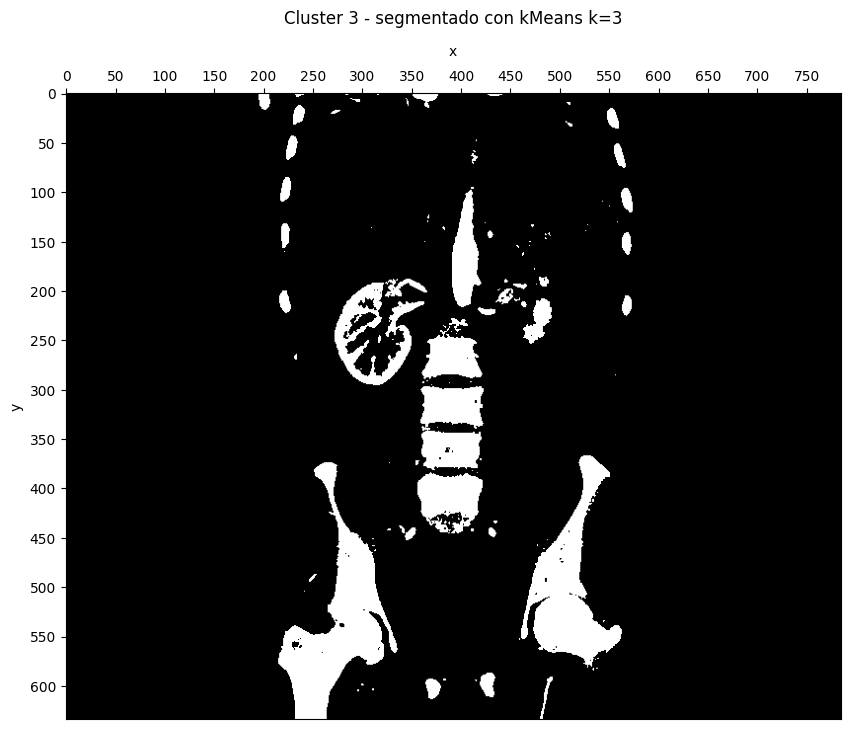

In [26]:
# solo me quiero quedar con el cluster 3 
clusters = np.unique(imgKMeans) # obtengo las etiquetas de los clusters
cluster3 = imgKMeans == clusters[2]

# Mostramos la imagen segmentada resultante
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cluster3, cmap='gray')

# Acomodamos el título y los ejes
ax.set_title(f'Cluster 3 - segmentado con kMeans k=3', pad = 50)
ax.set_xlabel('x')
x = (cluster3).shape[1]
ax.set_xticks(np.arange(0, x, 50))
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = (cluster3).shape[0]
ax.set_yticks(np.arange(0, y, 50))

# Mostramos la imagen
plt.show()



# Bounding Box


Vamos a usar boundingBox para contar cuantos objetos pertenecen a cada cluster segmentado por K means. Para eso defino una función que realiza el boundingBox.

In [27]:
def getBoundingBox(segmentedImg: np.ndarray, colorize: bool = False) -> tuple[np.ndarray, int]:
    """
    Encuentra y dibuja rectángulos de delimitación alrededor de los objetos presentes en una imagen segmentada.

    Args:
        segmentedImg: Una matriz NumPy que representa la imagen segmentada. Los valores distintos de cero indican la presencia de un objeto.
        colorize: Un booleano que indica si se deben dibujar los rectángulos de delimitación con diferentes colores.

    Returns:
        Una tupla que contiene la imagen con los rectángulos de delimitación dibujados y la cantidad de objetos encontrados.

    """
    height = segmentedImg.shape[0]
    width = segmentedImg.shape[1]
    labeledImg = np.zeros([height, width])
    boundingBoxImg = np.copy(segmentedImg)
    neighborhood = [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]
    label = 2
    objectCount = 0

    for i in range(height):
        for j in range(width):
            if segmentedImg[i, j] == 1 and labeledImg[i, j] == 0:
                seed = [i, j]
                neighborList = [seed]
                xMax = 0
                yMax = 0
                xMin = height
                yMin = width

                while len(neighborList) > 0:
                    x, y = neighborList.pop(0)

                    if x < xMin:
                        xMin = x
                    if x > xMax:
                        xMax = x
                    if y < yMin:
                        yMin = y
                    if y > yMax:
                        yMax = y

                    if segmentedImg[x, y] == 1 and labeledImg[x, y] == 0:
                        labeledImg[x, y] = label
                        boundingBoxImg[x, y] = 1

                        for k in range(8):
                            neighborX = x + neighborhood[k][0]
                            neighborY = y + neighborhood[k][1]

                            if 0 <= neighborX < height and 0 <= neighborY < width:
                                neighborList.append([neighborX, neighborY])

                if colorize:
                    boundingBoxImg[xMin, yMin:yMax+1] = label
                    boundingBoxImg[xMax, yMin:yMax+1] = label
                    boundingBoxImg[xMin:xMax+1, yMin] = label
                    boundingBoxImg[xMin:xMax+1, yMax] = label
                else:
                    boundingBoxImg[xMin, yMin:yMax+1] = 1
                    boundingBoxImg[xMax, yMin:yMax+1] = 1
                    boundingBoxImg[xMin:xMax+1, yMin] = 1
                    boundingBoxImg[xMin:xMax+1, yMax] = 1

                label += 1
                objectCount += 1

    return boundingBoxImg, objectCount


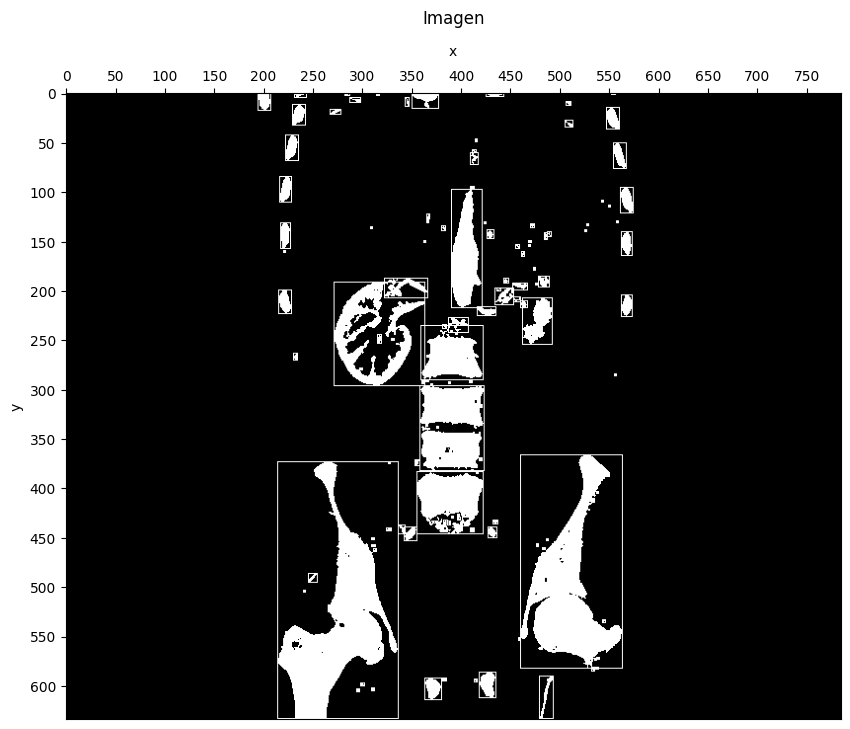

Número de objetos del cluster 3: 121


In [28]:
imgBox, numBoxes = getBoundingBox( cluster3 )


# Mostramos la imagen binaria resultante
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(imgBox, cmap='gray')

# Acomodamos el título y los ejes
ax.set_title(f'Imagen', pad = 50)
ax.set_xlabel('x')
x = (imgBox).shape[1]
ax.set_xticks(np.arange(0, x, 50))
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = (imgBox).shape[0]
ax.set_yticks(np.arange(0, y, 50))

# Mostramos la imagen
plt.show()

print(f'Número de objetos del cluster 3: {numBoxes}')

## Calculo de indices de Dice y Jaccard

Voy a usar los indices de Dice y Jaccard para comparar las segmentaciones obtenidas con kMeans implementado por mi, y por el método de librería visto en clase. Primero copio la función de kMeans de clase y la adapto para que tome una imagen de entrada y un número de clusters K. Mi implementación de kMeans es la ya utilizada.

In [29]:
def kMeansLibreria(img, kClusters):
  pixel_vals = img.reshape((-1)) 
  #el algortimo de cv2.kmeans nos pide este tipo de dato
  pixel_vals = np.float32(pixel_vals) 
  # Definir criterio de corte = ( type, max_iter = 10 , epsilon = 1.0 )
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.2)
  # Definir centroides
  flags = cv2.KMEANS_RANDOM_CENTERS
  # Aplicamos kmeans
  compactness,labels,centers = cv2.kmeans(pixel_vals,kClusters,None,criteria,100,flags)
  center = np.uint8(centers)
  img_kmeans = center[labels.flatten()]
  img_kmeans = img_kmeans.reshape((img.shape))
  
  return img_kmeans

Calculo (nuevamente) la segmentación con kMeans de la imagen original con mi implementación, y la segmentación con kMeans de librería. Luego calculo los indices de Dice y Jaccard entre ambas segmentaciones.

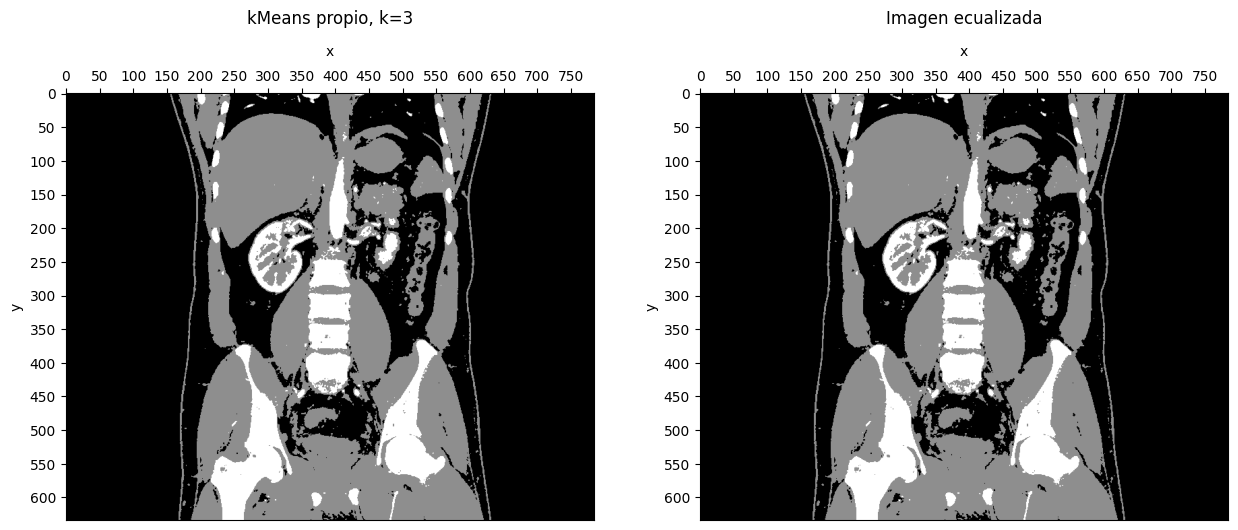

In [30]:
imgKMeansLibreria = kMeansLibreria(img12, 3)
imgKMeansBrisa = k_means(img12, 3)

# Mostramos la imagen comparada con la original una al lado de la otra
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# imagen original
ax[0].imshow(imgKMeansBrisa, cmap='gray')
ax[0].set_title('kMeans propio, k=3', pad = 50)
ax[0].set_xlabel('x')
x = imgKMeansBrisa.shape[1]
ax[0].set_xticks(np.arange(0, x, 50))
ax[0].xaxis.set_label_position('top')
ax[0].xaxis.labelpad = 10
ax[0].xaxis.set_ticks_position('top')
ax[0].set_ylabel('y')
y = imgKMeansBrisa.shape[0]
ax[0].set_yticks(np.arange(0, y, 50))

#imagen filtrada
# imagen original
ax[1].imshow(imgKMeansLibreria, cmap='gray')
ax[1].set_title('Imagen ecualizada', pad = 50)
ax[1].set_xlabel('x')
ax[1].set_xticks(np.arange(0, x, 50))
ax[1].xaxis.set_label_position('top')
ax[1].xaxis.labelpad = 10
ax[1].xaxis.set_ticks_position('top')
ax[1].set_ylabel('y')
ax[1].set_yticks(np.arange(0, y, 50))

plt.show()

A simple vista son muy similares, pero veamos que valores arrojan los indices de Dice y Jaccard para poder compararlas más objetivamente. Voy a  definir una función que calcule los indices de Dice y Jaccard. 

In [31]:
def diceIndex(trueLabels, predictedLabels, verbose=False):
    # Comprobar que las etiquetas tengan la misma longitud
    assert len(trueLabels) == len(predictedLabels)
    
    # Convertir las etiquetas a conjuntos
    trueSet = set(trueLabels)
    predictedSet = set(predictedLabels)
    
    # Calcular la intersección y la unión
    intersection = trueSet.intersection(predictedSet)
    union = trueSet.union(predictedSet)
    
    # Calcular el índice de Dice
    diceIndex = 2 * len(intersection) / (len(trueLabels) + len(predictedLabels))
    
    # Imprimir los resultados si verbose es True
    if verbose:
        print("True Labels: ", trueLabels)
        print("Predicted Labels: ", predictedLabels)
        print("Intersection: ", intersection)
        print("Union: ", union)
        print("Dice Index: ", diceIndex)
    
    # Devolver el índice de Dice
    return diceIndex


In [32]:
def jaccardIndex(trueLabels, predictedLabels, verbose=False):
    # Comprobar que las etiquetas tengan la misma longitud
    assert len(trueLabels) == len(predictedLabels)
    
    # Convertir las etiquetas a conjuntos
    trueSet = set(trueLabels)
    predictedSet = set(predictedLabels)
    
    # Calcular la intersección y la unión
    intersection = trueSet.intersection(predictedSet)
    union = trueSet.union(predictedSet)
    
    # Calcular el índice de Jaccard
    jaccardIndex = len(intersection) / len(union)
    
    # Imprimir los resultados si verbose es True
    if verbose:
        print("True Labels: ", trueLabels)
        print("Predicted Labels: ", predictedLabels)
        print("Intersection: ", intersection)
        print("Union: ", union)
        print("Jaccard Index: ", jaccardIndex)
    
    # Devolver el índice de Jaccard
    return jaccardIndex


In [33]:
# Obtengo las etiquetas
etiquetasLibreria = np.unique(imgKMeansLibreria)
etiquetasBrisa = np.unique(imgKMeansBrisa)

# Calculo los índices
print('### DICE INDEX ###')
dice = diceIndex(etiquetasBrisa, etiquetasLibreria, verbose=True)
print()
print('### JACCARD INDEX ###')
jaccard = jaccardIndex(etiquetasBrisa, etiquetasLibreria, verbose=True)

### DICE INDEX ###
True Labels:  [ 11 141 245]
Predicted Labels:  [ 11 141 245]
Intersection:  {11, 245, 141}
Union:  {245, 11, 141}
Dice Index:  1.0

### JACCARD INDEX ###
True Labels:  [ 11 141 245]
Predicted Labels:  [ 11 141 245]
Intersection:  {11, 245, 141}
Union:  {245, 11, 141}
Jaccard Index:  1.0


Vemos que ambos indicadores dan 1, esto implica que el resultado es similar